## TODO 

#### general: 

* General Analysis
* Try different Sentiment Analysis Tools
* Restructure Notebook
* ~Skip whole cells on parameter~


#### heute: 
* Check current dataset - especially with first day in before timespan
* Try different sentimet analysis tools
* 30 min research about alternatives
* Ideas about general Analysis tools

#### Mittwoch

* Start report
* Write Method section
* Introduction


# Data Literacy Student Project

### Main Question : Has the amount of transphobic tweets increased under Elon Musk?



This notebook was created as part of the team project for the Data Literacy course. The code for the data analysis project has been carried out in this jupyter notebook and is the work of 

    Fabian Köninger  4200890   fabian.koeninger@student.uni-tuebingen.de
    Markus Deppner   4106780   markus.deppner@student.uni-tuebingen.de
    
This project tackles the question if the amount of transphobic tweets has increased since the takeover of Twitter by Elon Musk. 
The background to this projecte idea aroused by Elon Musks 44 billion USD takeover of twitter on 27th of October 2022. 
One day after the takeover, on 28th of October 20222, Musk tweeted that "Anyone suspended for minor & dubious reasons will be freed from Twitter jail". Musk describes himself as an "absolutist of free speach", which lead to LGBTQ people that fear the harrassment they might face after the takeover. 

This notebook ist designed in the following structure:

### Outline

* [1. Setup](#setup_section)
* [2. Authentification](#authentification_section)
* [3. Composition of Dataset](#crawling_section)
* [4. General Data Anaylsis](#general_analysis)
* [5. Sentiment Analysis](#sentiment_analysis)
* [6. Wordcloud](#wordcloud)

### <a name="setup_section"></a> 1. Setup: Manage Installations Imports and Helper Functions

In [1]:
# Installations
# Comment out the following line in case you have not already included any of the following libraries 
# that are required for this notebook in your setup 
# 1. Tweepy
# 2. Textblob
# 3. Wordcloud

#!pip install tweepy
#!pip install textblob
#!python -m textblob.download_corpora
#!pip install wordcloud


#Imports
import tweepy
import json
import datetime 
import os
import pandas as pd
import csv
import time
import numpy as np
import matplotlib.pyplot as plt

from datetime import date, datetime, timedelta 
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from statistics import mean

In [2]:
# Found in this thread: https://stackoverflow.com/questions/26494747/simple-way-to-choose-which-cells-to-run-in-ipython-notebook-during-run-all
# This allows us to specifiy a parameter to skip cells when running the whole notebook

def skip(line, cell=None):
    '''Skips execution of the current line/cell if line evaluates to True.'''
    if eval(line):
        return

    get_ipython().ex(cell)

def load_ipython_extension(shell):
    '''Registers the skip magic when the extension loads.'''
    shell.register_magic_function(skip, 'line_cell')
    
load_ipython_extension(get_ipython())

In [3]:
# A parameter that needs to be set to true, to enable the crawling of tweets
# When changing this variable, you enable the request section actually requests will be sent to Twitters API and the results 
# will be stored in the file which you specified as fileName
compose_dataset = False

###  <a name="authentification_section"></a> 2. Authentifaction: Set Credentials to access the Twitter API

In [4]:
# Think of the API key as the user name that represents your App when making API requests. It helps us verify who you are.
# api_key = 'ejMMb5Cvj2d6s0gwDAJi3Y9Cc'  

# Your API Key Secret is like a password and helps verify your API Key. This will be one of the last times you'll see it displayed, so remember to save it in a safe place.
# api_key_secret= 'RNZEFHl3PAtQkxpZTC1YliGbfcSdjlL4SnuX6fnR1PWJ1xDbGW'

# An Access Token used in authentication that allows you to pull specific data.
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAIUAkwEAAAAAyQuxM73RN3fkHhDCy%2BConF0mzjg%3DIK6iouUoVLUcseqcoSOYs3wZYSRfsrlzXsfRO2ac5uk6EYTQX7'

os.environ['Twitter_Bearer_Token'] = bearer_token

In [5]:
def auth():
    return os.getenv('Twitter_Bearer_Token')

In [6]:
consumer_key = 'ejMMb5Cvj2d6s0gwDAJi3Y9Cc'
consumer_secret = 'RNZEFHl3PAtQkxpZTC1YliGbfcSdjlL4SnuX6fnR1PWJ1xDbGW'
access_token = '1600184977420963845-iCZd2SeMRDtUusQOJofjNDYtJadGNB'
access_secret = 'TFwzBo8ZzppEWfQX5n0Dq1jWhT9eHEjpu53tpjnOh5MCC'

client = tweepy.Client(
    bearer_token = auth(),
    consumer_key = consumer_key,
    consumer_secret = consumer_secret,
    access_token = access_token,
    access_token_secret = access_secret
)

###  <a name="crawling_section"></a> 3. Composition of Dataset

In this section we build and send the requests to Twitters API in order to retrieve and build our dataset for the analysis.
We want to get all the tweets during the timespam from 01.01.2022 to 31.12.2022 in order to cover a whole year and get a sufficient timespan before and after Elon Musks takeover. 

We crawl all tweets that contain specified keywords in their message and were created during our defined timespan. 

### Helper functions

In [7]:
"""
This function processes a response from Twitters API and converts it into a row that can be saved into our csv file. 
This funcrtion first opens or creates the name with the given filename, for each tweet extracts the information from the response
and appends this converted result in the csv later on. 


@ params  tweets: as a response from Twitters API
          fileName: name of the file to be created or opened
"""
def append_to_csv(tweets, fileName):

    #A counter variable
    counter = 0

    #Open or create the target CSV file
    csvFile = open(fileName, "a", newline="", encoding='utf-8')
    csvWriter = csv.writer(csvFile)

    #Loop through each tweet
    for tweet in tweets.data:
        
        # We will create a variable for each entry since some of the keys might not exist for some tweets
        # So we will account for that
        
        # Tweet Fields
    
        # 1. ID
        tweet_id = tweet['id']
        
        # 2. Text 
        text = tweet['text']
        
        # 3. Author ID
        author_id = tweet['author_id']

        # 4. Time created
        created_at = tweet['created_at']

        # 5. Conversation ID
        conversation_id = tweet['conversation_id']
        
        # 6. Entities
        entities = tweet['entities']
        
        # 7. In reply to User Id
        reply_to_user = tweet['in_reply_to_user_id']
        
        # 8. Language
        lang = tweet['lang']
        
        # 9. Possibly Sensitive
        possibly_sensitive = tweet['possibly_sensitive']
                  
        # 10. Tweet metrics
        retweet_count = tweet.public_metrics['retweet_count']    
        reply_count = tweet.public_metrics['reply_count']
        like_count = tweet.public_metrics['like_count']
        quote_count = tweet.public_metrics['quote_count']
        
    
        # Place Fields
        
        places_extension = tweets.includes['places'] if 'places' in tweets.includes else []
        
        # 11. Place ID
        if 'geo' in tweet:
            place_id = tweet.geo['place_id']
        else:
            place_id = None
        
        # 12. Place Name
        if 'geo' in tweet:
            place_id = tweet.geo['place_id']
            place = [place for place in places_extension if place.id == place_id ][0]
            place_name = place.full_name
        else: 
            place_name = None
        
        
        # User Fields  
        
        users_extension = tweets.includes['users'] if 'users' in tweets.includes else []
        
        # 13. Name of User
        if 'author_id' in tweet: 
            user_full_name = [user.name for user in users_extension if user.id == author_id ][0]
        else: 
            user_full_name = None
            
        # 14. Username
        if 'author_id' in tweet: 
            username = [user.username for user in tweets.includes['users'] if user.id == author_id ][0]
        else: 
            username = None
            
        
        # Assemble all data in a list 
        res = [tweet_id, 
               text, 
               author_id, 
               created_at, 
               conversation_id, 
               entities, 
               reply_to_user, 
               lang, 
               possibly_sensitive,
               retweet_count,
               reply_count,
               like_count, 
               quote_count, 
               place_id, 
               place_name,
               user_full_name, 
               username]
        
        # Append the result to the CSV file
        csvWriter.writerow(res)
        counter += 1

    # When done, close the CSV file
    csvFile.close()

    # Print the number of tweets for this iteration
    print("# of Tweets added from this response: ", counter) 

In [8]:
def days_in_between(startdate, enddate):
    startdates = []
    enddates   = []
    while startdate < enddate:
        startdates.append(startdate)
        startdate += timedelta(days=1)
        enddates.append(startdate)
    return startdates, enddates

### Request Section 

Our dataset 

Step 1:  Open a file in which the data is stored

Step 2: Define the request parameteres to start the request

Step 3: Iterate through the responses until all data that contain our keywords in the give timespan are crawled 

### Step 1 Specify all parameters

In [10]:
# Specify start and end dates for the timeperiod before and after the takeover
# The timespan is defined such that we take the days from a present date up to the date of when the acquistion was completed.
# From that day of the acquisition we go the same timespan back in time such that we obtain equally large parts of the time
# before and after the takover.

date_of_acquisition = datetime(2022,10,27,0,0,0)

# Timespan after the acquisition
enddate_after = datetime(2023,1,21,0,0,0)
startdate_after = date_of_acquisition

startdates_after, enddates_after = days_in_between(startdate_after, enddate_after)

# Timespan before the acquisition
difference_in_days = (enddate_after - date_of_acquisition).days
startdate_before = date_of_acquisition - timedelta(days = difference_in_days)
enddate_before   = date_of_acquisition 

startdates_before, enddates_before = days_in_between(startdate_before, enddate_before)

In [11]:
# Setup parameters for request

keywords     = '(LGBTQ OR LGBTQI OR "LGBTQI+" OR "LGBTQIA+" OR "LGBTQIA*" OR trans OR queer OR gay OR lesbian OR bisexual OR 🌈 OR LesBiGay OR homo OR tranny OR trannie) -"RT"'
query        = keywords + ' -is:retweet lang:en place_country:US'
tweet_fields = 'id,text,author_id,created_at,conversation_id,entities,in_reply_to_user_id,lang,possibly_sensitive,public_metrics'
expansions   = 'geo.place_id,author_id'
place_fields = 'id,full_name,country,geo'
user_fields  = 'id,name,username,description'

# Parameters for looping requests
max_results_per_request = 500 
max_limit_per_day       = 30000
tweet_count             = 0

fileName     = 'data_opsi.csv'



### Step 2 Create a csv file with header in which the data is saved

In [20]:
%%skip not compose_dataset # This cell is skipped by default if the parameter to compse the dataset is not set to True
 

# Create or open file
csvFile = open(fileName, "a", newline="", encoding='utf-8')
csvWriter = csv.writer(csvFile)

# Create a header in the csv for the data we want to save
csvWriter.writerow(['id', 
                    'text', 
                    'author_id',
                    'created_at', 
                    'conversation_id', 
                    'entities', 
                    'in_reply_to_user_id',
                    'lang', 
                    'possibly_sensitive',
                    'retweet_count', 
                    'reply_count', 
                    'like_count', 
                    'quote_count', 
                    'place_id', 
                    'place_name',
                    'user_full_name', 
                    'username'])
csvFile.close()


### Step 3 Send multiple requests to compose dataset

In [21]:
%%skip not compose_dataset # This cell is skipped by default if the parameter to compse the dataset is not set to True


for startdate,  enddate in zip(startdates_after, enddates_after):
    time.sleep(30)
    flag = True
    next_token  = None
    tweet_count = 0
    iteration   = 0

    while flag: 
        if tweet_count >= max_limit_per_day:
            break


        print("-------------------")
        print("Iteration: " + str(iteration))
        print("Token: ", next_token)

        # Perform initial request on Twitters API 
        tweets = client.search_all_tweets(
            query=query, 
            start_time=startdate, 
            end_time=enddate, 
            tweet_fields = tweet_fields,
            expansions = expansions,
            place_fields = place_fields,
            user_fields = user_fields,
            max_results = max_results_per_request,
            next_token = next_token
        )

        result_count = tweets.meta['result_count']

        if('next_token' in tweets.meta):
            # Save the token to use for next call       
            next_token = tweets.meta['next_token']
            print("Next Token: ", next_token)
            if(result_count is not None and result_count > 0 and next_token is not None):
                append_to_csv(tweets, fileName)
                iteration += 1
                tweet_count += result_count
                print("Total # of Tweets added: ", tweet_count)
                print("-------------------")
                time.sleep(10)  

        # If no next token exists
        else: 
            if result_count is not None and result_count > 0:
                print("-------------------")
                append_to_csv(tweets, fileName)
                tweet_count += result_count
                print("Total # of Tweets added: ", tweet_count)
                print("-------------------")
                time.sleep(10)
                

            flag = False
            next_token = None
            time.sleep(10)
    print("Total number of results: ", tweet_count)

###  <a name="general_analysis"></a> 4. General Analysis


### Interesting metrics

* Who was the user that posted the most
* From where do most of the tweets come from? location wise?


#### Load the previously created dataset

In [48]:
df = pd.read_csv('data.csv') # TODO change to fileName

# Cast the column 'created_at' which stores the timestamp of the tweet to a datetime such that we can easily compre them
df['created_at'] = pd.to_datetime(df.created_at).dt.tz_localize(None)

### <a name="sentiment_analysis"></a> 5. Sentitment analysis

In [33]:
avg_polar = 0.
avg_subj = 0.
count = 0
polarities = np.zeros(df.shape[0])
subjectivities = np.zeros(df.shape[0])

for index, tweet in df.iterrows():
    text = tweet['text']
    blob = TextBlob(text)
    count+=1

    polar = blob.sentiment[0]    # Polarity between -1, 1
    subj = blob.sentiment[1]     # Subjectivity
    polarities[index] = polar
    subjectivities[index] = subj
    
    avg_polar +=polar
    avg_subj +=subj
   
    
print("Number of tweets analysed: ", count)
print("Average polarity: ", avg_polar/count)
print("Average subjectivity: ", avg_subj/count)

Number of tweets analysed:  217011
Average polarity:  0.18539475869131855
Average subjectivity:  0.47084675080819244


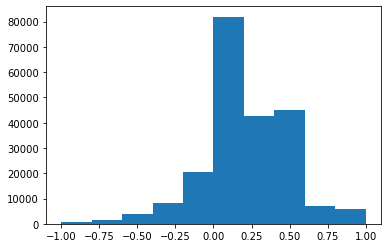

In [34]:
pol_values, pol_bins, _ = plt.hist(polarities)

In [ ]:
subj_values, subj_bins, _ = plt.hist(subjectivities)

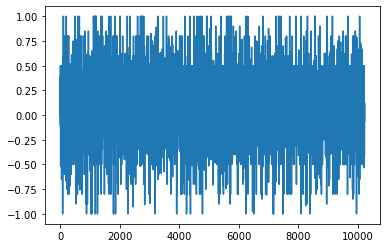

In [15]:
plt.plot(polarities)

In [92]:
df['created_at'] = pd.to_datetime(df.created_at).dt.tz_localize(None)

In [109]:
#polarities_per_day = []
#subjectivity_per_day = []


for startdate, enddate in zip(startdates_after, enddates_after):
    df_temp = df.loc[(df['created_at'] >= startdate) & (df['created_at'] < enddate)]
    
    polarities = []
    subjectivities = []
    count = 0
    for index, tweet in df_temp.iterrows():
        text = tweet['text']
        blob = TextBlob(text)
        
        polar = blob.sentiment[0]    # Polarity between -1, 1
        subj = blob.sentiment[1]     # Subjectivity
        polarities.append(polar)
        subjectivities.append(subj)
        count += 1
                
    print("Day: " + str(startdate))
    print("Number of tweets analysed: ", count)
    print("Average polarity: ", mean(polarities))
    print("Average subjectivity: ", mean(subjectivities))
    
    polarities_per_day.append(mean(polarities))
    subjectivity_per_day.append(mean(subjectivities))


Day: 2022-10-27 00:00:00
Number of tweets analysed:  1267
Average polarity:  0.1753373441885825
Average subjectivity:  0.46474195242754973
Day: 2022-10-28 00:00:00
Number of tweets analysed:  1286
Average polarity:  0.17101009734507738
Average subjectivity:  0.4599764038311167
Day: 2022-10-29 00:00:00
Number of tweets analysed:  1321
Average polarity:  0.17610260336200803
Average subjectivity:  0.4447195562865127
Day: 2022-10-30 00:00:00
Number of tweets analysed:  1539
Average polarity:  0.19042606630699677
Average subjectivity:  0.4775376352485213
Day: 2022-10-31 00:00:00
Number of tweets analysed:  1327
Average polarity:  0.18539377070156204
Average subjectivity:  0.4846275087541527
Day: 2022-11-01 00:00:00
Number of tweets analysed:  1380
Average polarity:  0.16860365583475623
Average subjectivity:  0.4689183098034547
Day: 2022-11-02 00:00:00
Number of tweets analysed:  1226
Average polarity:  0.17339267997166935
Average subjectivity:  0.4517899810297853
Day: 2022-11-03 00:00:00
Nu

Day: 2022-12-26 00:00:00
Number of tweets analysed:  716
Average polarity:  0.19773297295436715
Average subjectivity:  0.4869734935768123
Day: 2022-12-27 00:00:00
Number of tweets analysed:  942
Average polarity:  0.1686862670010659
Average subjectivity:  0.4843757772744383
Day: 2022-12-28 00:00:00
Number of tweets analysed:  974
Average polarity:  0.16473578087839108
Average subjectivity:  0.46890196816929364
Day: 2022-12-29 00:00:00
Number of tweets analysed:  1043
Average polarity:  0.18554726607563343
Average subjectivity:  0.48241948106401605
Day: 2022-12-30 00:00:00
Number of tweets analysed:  966
Average polarity:  0.1970145987642128
Average subjectivity:  0.4897154473590008
Day: 2022-12-31 00:00:00
Number of tweets analysed:  916
Average polarity:  0.1943047744331994
Average subjectivity:  0.4749051057632526
Day: 2023-01-01 00:00:00
Number of tweets analysed:  915
Average polarity:  0.2261123423438912
Average subjectivity:  0.5059387688291604
Day: 2023-01-02 00:00:00
Number of 

StatisticsError: mean requires at least one data point

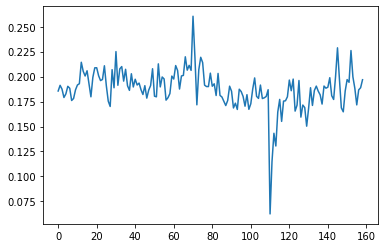

In [110]:
plt.plot(polarities_per_day)

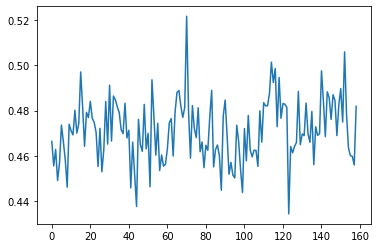

In [112]:
plt.plot(subjectivity_per_day)

(array([ 1.,  0.,  1.,  1.,  4., 47., 75., 26.,  3.,  1.]),
 array([0.06248171, 0.08228037, 0.10207903, 0.12187769, 0.14167636,
        0.16147502, 0.18127368, 0.20107234, 0.22087101, 0.24066967,
        0.26046833]),
 <BarContainer object of 10 artists>)

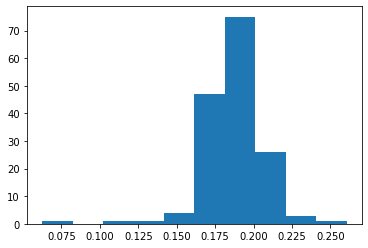

In [111]:
plt.hist(polarities_per_day)

In [103]:
df_temp

,id,text,author_id,created_at,conversation_id,entities,in_reply_to_user_id,lang,possibly_sensitive,retweet_count,reply_count,like_count,quote_count,place_id,place_name,user_full_name,username
1028,1554980060779536385,New products are available 🌈❤️✨\nWaterproof st...,1042380425367216133,2022-08-03 23:58:31,1554980060779536385,"{'annotations': [{'start': 84, 'end': 87, 'pro...",NaN,en,False,1,0,4,0,8fa6d7a33b83ef26,"Paradise, NV",KAKERA STAR,KakeraStar
1029,1554979841329377281,Legacy Project summer yacht party and I’m on t...,127428259,2022-08-03 23:57:38,1554979841329377281,"{'annotations': [{'start': 0, 'end': 13, 'prob...",NaN,en,False,0,0,0,0,1d9a5370a355ab0c,"Chicago, IL",Jerry Nunn,jerrynunn
1030,1554979355247394823,Talking to one of my str8’s about how I hated ...,2721444028,2022-08-03 23:55:43,1554979355247394823,NaN,NaN,en,False,0,1,1,0,8173485c72e78ca5,"Atlanta, GA",Stream LD Green🏳️‍🌈,CuzinBey
1031,1554979306224361472,@teensith @punished_cait There was actually a ...,3122881616,2022-08-03 23:55:31,1554826246634188802,"{'annotations': [{'start': 111, 'end': 124, 'p...",2.010956e+07,en,False,0,1,3,0,095534ad3107e0e6,"Louisville, KY",Aria Baci ✨,MsBaci
1032,1554978106770857990,@AngelbunnyAA I want to be a lesbian LOL I'm s...,1510879775648272388,2022-08-03 23:50:45,1554266014979858432,"{'annotations': [{'start': 86, 'end': 92, 'pro...",1.401621e+18,en,False,0,0,0,0,2526edd24c06e60c,"Missouri, USA",Robert Krell,RobertKrell12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22596,1554619825372160003,Big up the BRICK 🧱💪🍆 DICK men from the Caribbe...,1285373483577466881,2022-08-03 00:07:04,1554619825372160003,"{'annotations': [{'start': 39, 'end': 47, 'pro...",NaN,en,False,0,0,2,0,00c39537733fa112,"Queens, NY",Starboi🌟💰🌹,Starboi4lifexx2
22597,1554619097685573634,"Also in here, Sen. Ron Johnson on his statemen...",1163618839,2022-08-03 00:04:10,1554619097685573634,"{'annotations': [{'start': 19, 'end': 29, 'pro...",NaN,en,False,3,2,12,5,01fbe706f872cb32,"Washington, DC",Andrew Solender,AndrewSolender
22598,1554618608071983106,You better believe I ordered Renaissance on vi...,19732618,2022-08-03 00:02:14,1554618608071983106,"{'annotations': [{'start': 29, 'end': 39, 'pro...",NaN,en,False,0,0,0,0,c0b8e8dc81930292,"Baltimore, MD",Meghann Harris They/Them,designeducated
22599,1554618352336863232,This is so me at gay gatherings! https://t.co/...,1434210087317430278,2022-08-03 00:01:13,1554618352336863232,"{'urls': [{'start': 33, 'end': 56, 'url': 'htt...",NaN,en,False,1,0,4,0,00da23b51c3aabc1,"Suitland, MD",NerdyNupe,NerdyNupeDC


In [94]:
df_temp = df.loc[(df['created_at'] >= start) & (df['created_at'] < end)]
df_temp

,id,text,author_id,created_at,conversation_id,entities,in_reply_to_user_id,lang,possibly_sensitive,retweet_count,reply_count,like_count,quote_count,place_id,place_name,user_full_name,username
0,1554617647874064384,taste it 🌈 https://t.co/DMu0hJHeHD,48376961,2022-08-02 23:58:25,1554617647874064384,"{'urls': [{'start': 11, 'end': 34, 'url': 'htt...",NaN,en,False,4,2,30,0,7c6e7f07a0fc0835,"South Burlington, VT",Darrell the Farmer🚶🏿,farmerdarrell
1,1554617242687610881,The fact that this happens with most Twitter p...,499934676,2022-08-02 23:56:48,1554613115127566339,"{'annotations': [{'start': 37, 'end': 43, 'pro...",4.999347e+08,en,False,0,0,0,0,9f3d755fe1a081a4,"Lombard, IL",Brendan Tynan Buck,RedCometKick
2,1554617164006555648,How does one find himself listening to this wh...,1342384032,2022-08-02 23:56:29,1554617164006555648,"{'urls': [{'start': 121, 'end': 144, 'url': 'h...",NaN,en,False,0,1,6,0,1d9a5370a355ab0c,"Chicago, IL",Conrad🏳️‍🌈,RNConrad
3,1554616376744034304,@kevinmax @The_DeConverted My rant. Why is the...,1346964547723169793,2022-08-02 23:53:22,1554288723809951744,"{'urls': [{'start': 296, 'end': 319, 'url': 'h...",1.466349e+07,en,False,0,0,0,0,4f5e07211d107837,"Sierra Vista, AZ",Harris Rosenberg,RickRos00489123
4,1554616321383534592,trans 🥺😩 dm me,1499045078018449411,2022-08-02 23:53:09,1554616321383534592,NaN,NaN,en,False,0,0,0,0,a9b50065bfbb3fa9,"Grand Prairie, TX",JayLon,freakyJL2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,1554257045129351168,@TransfersMLS Rumors in Spain are that he’s re...,49359295,2022-08-02 00:05:30,1554237141005307904,"{'annotations': [{'start': 24, 'end': 28, 'pro...",7.485825e+17,en,False,0,1,0,0,10de09f288b1665c,"Pasadena, CA",Galactic Nucleus,GalacticSince96
1024,1554257026854920195,Say that you a lesbian girl me too,807929862,2022-08-02 00:05:26,1554257026854920195,NaN,NaN,en,False,0,0,1,0,00c6c3cd3e783197,"Augusta, GA",thebby 🤍,chasityariel_
1025,1554257005082198016,Hey guys 💦💦💦\nFun&amp;Friendly pre/post cruise...,1325464724482498560,2022-08-02 00:05:21,1554257005082198016,"{'annotations': [{'start': 99, 'end': 102, 'pr...",NaN,en,True,2,0,21,0,01a9a39529b27f36,"Manhattan, NY",KostaViking - NewYork 01-15/02.10,KostaViking
1026,1554256881241264131,Drake is so gay NFS,807929862,2022-08-02 00:04:51,1554256881241264131,"{'annotations': [{'start': 0, 'end': 4, 'proba...",NaN,en,False,0,0,0,0,00c6c3cd3e783197,"Augusta, GA",thebby 🤍,chasityariel_


### <a name="wordcloud"></a> 6. Wordcloud

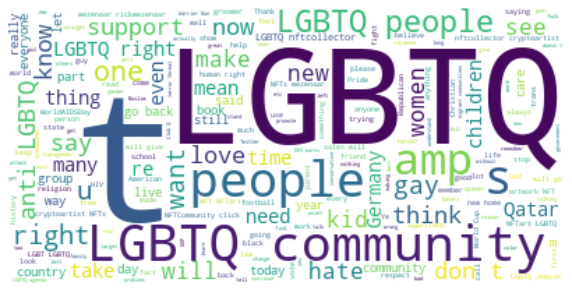

In [11]:
# Create a list of word
text= " ".join(tweet['text'] for index, tweet in df.iterrows())

# Create a stopword list
stopwords = set(STOPWORDS)
stopwords.update(["http", "https", "co"])

# Create the wordcloud object
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
 
# Display the generated image (matplotlib way):
plt.figure(figsize = (10, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()